# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# EDA, clean & transform data

## Portfolio dataframe
- encode offer id string with easier to interpret values (0, 9), set the new offer id column name = offer_id_2

In [2]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [3]:
# encode offer id with more simple value, set the new column name = offer_id_2
portfolio = portfolio.reset_index()
portfolio.rename(columns={'index':'offer_id_2'}, inplace=True)

In [4]:
# create a dictionary of original offer id string (key) and new offer_id_2 (value), 
# which can be used to map new offer_id_2 to other dataframes
offer_id_2_dict = {list(portfolio['id'])[i]: list(portfolio['offer_id_2'])[i] for i in range(len(list(portfolio['id'])))} 

In [5]:
# update portfolio df with only relevant columns
portfolio = portfolio[['offer_id_2', 'reward', 'channels', 'difficulty', 'duration', 'offer_type']]

In [6]:
portfolio

,offer_id_2,reward,channels,difficulty,duration,offer_type
0,0,10,"[email, mobile, social]",10,7,bogo
1,1,10,"[web, email, mobile, social]",10,5,bogo
2,2,0,"[web, email, mobile]",0,4,informational
3,3,5,"[web, email, mobile]",5,7,bogo
4,4,5,"[web, email]",20,10,discount
5,5,3,"[web, email, mobile, social]",7,7,discount
6,6,2,"[web, email, mobile, social]",10,10,discount
7,7,0,"[email, mobile, social]",0,3,informational
8,8,5,"[web, email, mobile, social]",5,5,bogo
9,9,2,"[web, email, mobile]",10,7,discount


## Profile dataframe
- drop rows with null income, age = 118, gender = None: these are likely were generated by errors, and don't add value to the analysis
- create dummy variables for the gender column
- create days_since_became_member from the became_member_on column

In [7]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [8]:
# check rows with age = 118
profile[profile['age'] == 118].head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


In [9]:
# check null values in these rows with age = 118
profile[profile['age'] == 118].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 16994
Data columns (total 5 columns):
gender              0 non-null object
age                 2175 non-null int64
id                  2175 non-null object
became_member_on    2175 non-null int64
income              0 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 102.0+ KB


In [10]:
# drop rows with null income, age = 118, gender = None
profile.dropna(axis=0, how='any', inplace=True)

In [11]:
# encode 'gender' with numeric value, by creating dummy variables
profile = pd.concat([profile, pd.get_dummies(profile['gender'], prefix='gender')], axis=1, sort=False)

In [12]:
profile.head()

,gender,age,id,became_member_on,income,gender_F,gender_M,gender_O
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,1,0,0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,0,1,0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,0,1,0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,0,1,0


In [13]:
# create days_since_became_member column from the became_member_on column
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d', errors='ignore')
profile['days_since_became_member'] = (datetime.datetime.now().date() - profile['became_member_on'].dt.date).dt.days

In [14]:
profile.head()

,gender,age,id,became_member_on,income,gender_F,gender_M,gender_O,days_since_became_member
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0,1035
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0,1102
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,0,1,0,750
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,0,1,0,826
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,0,1,0,916


## Transcript dataframe
- extract info from the 'value' column, by create 4 separate df: offer received, offer viewed,  offer completed, transaction
- for dataframes with offer_id_value column, replace it with a simplier id as in the offer_id_2_dict_dictionary created earlier

In [15]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [16]:
# summary of offer received, offer viewed, offer completed, transaction 
transcript.groupby(['event'])['person'].count().sort_values

<bound method Series.sort_values of event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64>

In [17]:
# find the key(s) for the dictionary in the value column for each of the event
events = list(transcript['event'].unique())
for event in events:
    event_dict_keys = transcript[transcript['event'] == event].value.values[0].keys()
    print(event,': ', event_dict_keys)

offer received :  dict_keys(['offer id'])
offer viewed :  dict_keys(['offer id'])
transaction :  dict_keys(['amount'])
offer completed :  dict_keys(['offer_id', 'reward'])


In [60]:
# create value columns for each each type
events = list(transcript['event'].unique())
result = pd.DataFrame()

for event in events:
    df = transcript[transcript['event'] == event]
    df = df.reset_index()

    offer_id_values = []
    offer_rewards = []
    transaction_values = []
    
    for i in range(len(df)):
        if list(df.value.values[0].keys())[0] == 'offer id':
            offer_id_value = df.value.values[i].get('offer id')
        if list(df.value.values[0].keys())[0] == 'offer_id':
            offer_id_value = df.value.values[i].get('offer_id')

        offer_id_values.append(offer_id_value)

        offer_reward = df.value.values[i].get('reward')
        offer_rewards.append(offer_reward)

        transaction_value = df.value.values[i].get('amount')
        if type(transaction_value) == float:
            transaction_value = round(transaction_value, 2)
        transaction_values.append(transaction_value)

    if offer_id_values[0] != None:
        df['offer_id_value'] = offer_id_values
    else:
        df['offer_id_value'] = np.NaN

    if offer_rewards[0] != None:
        df['offer_reward'] = offer_rewards
    else:
        df['offer_reward'] = np.NaN

    if transaction_values[0] != None:
        df['transaction_value'] = transaction_values
    else:
        df['transaction_value'] = np.NaN
    
    result = pd.concat([df, result], axis=0, sort=False)

In [63]:
# create a new column for simplier offer id using offer_id_2_dict dictionary
result['offer_id_2'] = result['offer_id_value']
result['offer_id_2'].replace(offer_id_2_dict, inplace=True)

# Data analysis

In [96]:
# create offer_completed data frame which contains only offer completed event
offer_completed = result[result['event'] == 'offer completed']

# create offer_viewed data frame which contains only offer viewed event
offer_viewed = result[result['event'] == 'offer viewed']

# create offer_received data frame which contains only offer received event
offer_received = result[result['event'] == 'offer received']

# create transaction data frame which contains only transaction event
transaction = result[result['event'] == 'transaction']

In [73]:
# create a function to count number of offer completed not view by customer for each offer id

def no_completed_not_view_person(offer_id):
    
    # create df1 = dataframe of offer completed by person
    df1 = pd.DataFrame(offer_completed.groupby(['person', 'offer_id_2'])['person'].count().unstack()[offer_id])
    df1.rename(columns={offer_id:'offer_completed'}, inplace=True)
    
    # create df2 = dataframe of offer viewed by person
    df2 = pd.DataFrame(offer_viewed.groupby(['person', 'offer_id_2'])['person'].count().unstack()[offer_id])
    df2.rename(columns={offer_id:'offer_viewed'}, inplace=True)
    
    # create df3 = combine of df1 & df2, caculate the difference between completed & viewed
    df3 = pd.concat([df1, df2], sort=False)
    df3.fillna(0, inplace=True)
    df3[str(offer_id) + '_completed_not_view'] = df3['offer_completed'] - df3['offer_viewed']
    
    # create completed_not_view df
    completed_not_view = df3[df3[str(offer_id) + '_completed_not_view'] > 0]
    completed_not_view = completed_not_view[[str(offer_id) + '_completed_not_view']]
    
    return completed_not_view

In [74]:
# create completed_not_view_master df
completed_not_view_master = pd.DataFrame()

for i in [0,1,3,4,5,6,8,9]:
    df = no_completed_not_view_person(i)
    completed_not_view_master = pd.concat([df, completed_not_view_master], axis=1, sort=False)
    
completed_not_view_master

,9_completed_not_view,8_completed_not_view,6_completed_not_view,5_completed_not_view,4_completed_not_view,3_completed_not_view,1_completed_not_view,0_completed_not_view
0009655768c64bdeb2e877511632db8f,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
0069a50874d846438e58acff5e594725,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00715b6e55c3431cb56ff7307eb19675,1.0,NaN,NaN,NaN,2.0,NaN,1.0,1.0
00840a2ca5d2408e982d56544dc14ffd,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN
00bbce6533f44ddeaf4dd32bcab55441,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...
f8ffe55acdb5412ea71fb1055f116733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
f92d608f58bf40178cc3c9568750c559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
fbb1d7819d564c489f4b196818d6026c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
fbb3b9c1faa3415cb04bde73f584f06a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [75]:
# find list of customers who are likely to completed the offer without viewing it
completed_not_view_master['total_completed_not_view'] = completed_not_view_master.sum(axis=1)
completed_not_view_master.sort_values(by=['total_completed_not_view'], ascending=False)

,9_completed_not_view,8_completed_not_view,6_completed_not_view,5_completed_not_view,4_completed_not_view,3_completed_not_view,1_completed_not_view,0_completed_not_view,total_completed_not_view
f1d65ae63f174b8f80fa063adcaa63b7,2.0,1.0,NaN,NaN,1.0,1.0,NaN,1.0,6.0
7ba2327c339f4081b2a94293df048b4d,NaN,NaN,NaN,1.0,3.0,NaN,1.0,1.0,6.0
762384c7198a4af8b1773400d8ec0335,1.0,2.0,NaN,NaN,1.0,NaN,1.0,1.0,6.0
e130d81685ae45deb9fbf6d416084a1d,NaN,NaN,NaN,NaN,2.0,NaN,2.0,2.0,6.0
4db19c668503480794c5f97c1a50ae69,2.0,NaN,NaN,1.0,1.0,1.0,1.0,NaN,6.0
...,...,...,...,...,...,...,...,...,...
6b44b3e1ade7466fb73824b4898f8716,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
87244fc214644f6584944d8180991601,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
6b2b97b27010464eb55e3c9ce06ec585,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
6b2b7e8a31b742d7b9440b4a7ae9c075,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [76]:
# count number of customers completed the offer without viewing it by frequency
completed_not_view_master.groupby(['total_completed_not_view'])['total_completed_not_view'].count().sort_values()

total_completed_not_view
6.0     200
5.0     969
4.0    2201
3.0    3062
1.0    3140
2.0    3202
Name: total_completed_not_view, dtype: int64

In [77]:
# percentage of offer completed without viewing out of total offer received
(completed_not_view_master.groupby(['total_completed_not_view'])['total_completed_not_view'].count().sort_values() / offer_received['person'].nunique() *100)

total_completed_not_view
6.0     1.176886
5.0     5.702012
4.0    12.951630
3.0    18.018124
1.0    18.477110
2.0    18.841944
Name: total_completed_not_view, dtype: float64

**Comment:** as shown above, there are a considerable number of customers who completed the offer without viewing it.

- There are 200 customers (1.18% of total customers) completed 6 offers without viewing them
- There are 969 customers (5.70% of total customers) completed 5 offers without viewing them
- There are 2201 customers (12.95% of total customers) completed 4 offers without viewing them
- There are 3062 customers (18.02% of total customers) completed 3 offers without viewing them

These info gives us an idea with customer are likely to spend without an offer (= not knowing/viewing the offer), and decide whether or not in the future to reduce the offer sent to these customers. This move can help us increase revenue & reduce the reward sent without an impact on customer buying behaviour.

In [78]:
# count number of customers completed the offer without viewing it by offer id
completed_not_view_by_offerid = pd.DataFrame(completed_not_view_master.sum(axis=0))
completed_not_view_by_offerid = completed_not_view_by_offerid.reset_index()
completed_not_view_by_offerid.rename(columns={0:'total_completed_not_view', 'index':'offer'}, inplace=True)
completed_not_view_by_offerid.sort_values(by=['offer'], inplace=True)
completed_not_view_by_offerid = completed_not_view_by_offerid.drop([8], axis=0).sort_values(by=['offer'])
completed_not_view_by_offerid = completed_not_view_by_offerid.reset_index()
completed_not_view_by_offerid.drop(['index'], axis=1, inplace=True)

# count number of customers received the offer by offer id
offer_received_by_offerid = pd.DataFrame(offer_received.groupby(['offer_id_2'])['person'].count()).reset_index().drop([2,7], axis=0)
offer_received_by_offerid.rename(columns={'person':'total_received'}, inplace=True)

# create offer_id_2 column used to combine with offer_received_by_offer_id dataframe
offer_ids = []
for i in range(len(completed_not_view_by_offerid)):
    offer_id = int(completed_not_view_by_offerid['offer'][i][0])
    offer_ids.append(offer_id)
    
completed_not_view_by_offerid['offer_id_2'] = offer_ids

# combine completed_not_view_by_offerid & offer_received_by_offerid
completed_not_view_by_offerid_summary = pd.concat([completed_not_view_by_offerid.set_index('offer_id_2'), offer_received_by_offerid.set_index('offer_id_2')], axis=1, sort=False)

# drop unrequired columns
completed_not_view_by_offerid_summary.drop(['offer'], axis=1, inplace=True)

# caculate % of completed offer not view out of total offer received by offer id
completed_not_view_by_offerid_summary['%_completed_not_view'] = completed_not_view_by_offerid_summary['total_completed_not_view'] / completed_not_view_by_offerid_summary['total_received'] * 100

Text(0.5, 1.0, 'Number of offers received and offers completed not view')

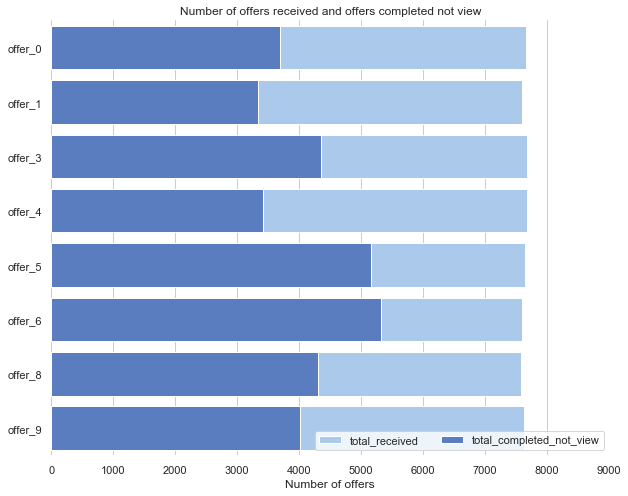

In [79]:
sns.set(style="whitegrid")

# load the dataset
data = completed_not_view_by_offerid_summary.reset_index()[['offer_id_2','total_completed_not_view','total_received']]
data['offer_id_2'] = data['offer_id_2'].apply(str)
data['offer_id_2'] = 'offer_' + data['offer_id_2']

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Plot the total offer received
sns.set_color_codes("pastel")
sns.barplot(x="total_received", y="offer_id_2", data=data,
            label="total_received", color="b")

# Plot the total completed not view
sns.set_color_codes("muted")
sns.barplot(x="total_completed_not_view", y="offer_id_2", data=data,
            label="total_completed_not_view", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 9000), ylabel="",
       xlabel="Number of offers")
sns.despine(left=True, bottom=True)
ax.set_title('Number of offers received and offers completed not view')

**Comment:** as the above summary table & bar chart shown, at least over 40% of offers received across all offer types were completed without viewing. This is a significant number. From this we can even estimate the lost of revenue (total reward given) from these offers which didn't have an impact on encouraging the customers to make purchases.

# Clustering (customer segmentation)
- perform clustering on profile_offer_completed data to find groups that tends to respond to specific offers
> 1. Use Elbow method to estimate the best guess for number of clusters (k)
> 2. Apply clustering methods: K-means, K-modes
> 3. Perform PCA & plot the segments with 2 dimentional space
> 4. Use the Silhouette Scores method to evaluating clustering given the visualisation with PCA is not the best. Confirm the better clustering method


In [80]:
# number of offer completed of each offer type by customer id
offer_completed_bycus = offer_completed.groupby(['person','offer_id_2'])['event'].count().unstack().reset_index()

offer_completed_bycus.rename(columns={
    0:'0_completed',
    1:'1_completed',
    2:'2_completed',
    3:'3_completed',
    4:'4_completed',
    5:'5_completed',
    6:'6_completed',
    7:'7_completed',
    8:'8_completed',
    9:'9_completed',
}, inplace=True)

offer_completed_bycus.fillna(0, inplace=True)

In [81]:
# create df with offer completed by customer id, and customer profile
profile_offer_completed = pd.concat([offer_completed_bycus.set_index('person'), profile.set_index('id')], axis=1, sort=False)

In [82]:
# select rows where customers responded to offer and we have customer profile data
profile_offer_completed = profile_offer_completed[profile_offer_completed['age'].notna()]

In [83]:
# fillna with 0 for those customer in profile, didn't respond to any of the offers
offer_completed_bycus.fillna(0, inplace=True)

##### 1. Use Elbow method to estimate the best guess for number of clusters (k)

In [88]:
# determine the number of clusters using the elbow method

from sklearn import cluster

ss = []

krange = list(range(2,11))

cols = offer_completed_bycus.columns[1:]

X = offer_completed_bycus[cols].values

for n in krange:
    model = cluster.KMeans(n_clusters=n, random_state=10)
    
    model.fit_predict(X)
    
    cluster_assignments = model.labels_
    
    centers = model.cluster_centers_
    
    ss.append(np.sum((X - centers[cluster_assignments]) ** 2))

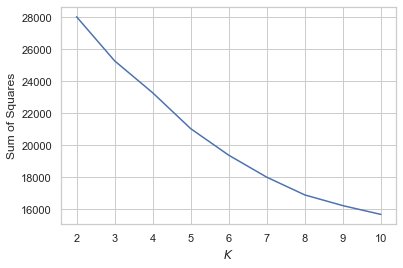

In [89]:
# create a plot with k on the x-axis and the squared error on the y-axis

plt.plot(krange, ss)

plt.xlabel("$K$")

plt.ylabel("Sum of Squares")

plt.show()

**Comment:** as above chart shown, the point where the 'elbow' is approx k = 8. Hence, we will apply k=8 according to this result.

##### 2. Apply clustering methods: K-means, K-modes

In [90]:
offer_cols = cols

# perform k-means with k = 8

from sklearn import cluster

kmeans = cluster.KMeans(n_clusters=8, random_state=10)
offer_completed_bycus['kmeans_cluster'] = kmeans.fit_predict(offer_completed_bycus[cols])

# perform k-modes with k = 8

from kmodes.kmodes import KModes

kmodes = KModes(n_clusters=8)
offer_completed_bycus['kmodes_cluster'] = kmodes.fit_predict(offer_completed_bycus[cols])


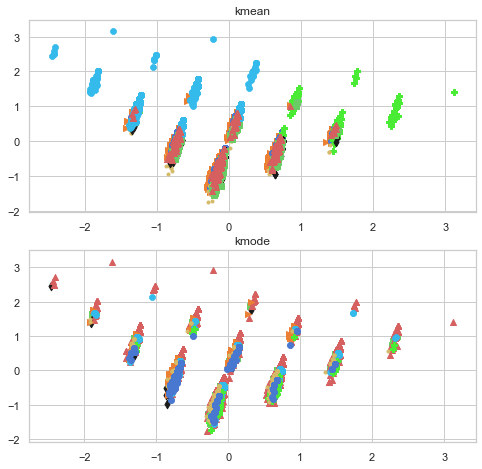

In [91]:
# perform PCA

from sklearn import decomposition

colors = ['r', 'b', 'k', 'g', 'y','#eb8034', '#34baeb', '#49eb34']
markers = ['^', 'o', 'd', 's', '.', '>', '8', 'P']

pca = decomposition.PCA(n_components=2)
offer_completed_bycus['pc1'], offer_completed_bycus['pc2'] = zip(*pca.fit_transform(offer_completed_bycus[offer_cols]))

# visualise the resulting clustering of k-modes and k-means method

plt.figure(figsize=(8,12))

# plot result of k-means method
ax = plt.subplot(3, 1, 1)
for c in offer_completed_bycus['kmeans_cluster'].unique():
    d = offer_completed_bycus[offer_completed_bycus['kmeans_cluster'] == c]
    plt.scatter(d['pc1'], d['pc2'], marker=markers[c], color=colors[c])    
ax.set_title('kmean')

# plot result of k-modes method
ax = plt.subplot(3, 1, 2)
for c in offer_completed_bycus['kmodes_cluster'].unique():
    d = offer_completed_bycus[offer_completed_bycus['kmodes_cluster'] == c]
    plt.scatter(d['pc1'], d['pc2'], marker=markers[c], color=colors[c])    
ax.set_title('kmode')

plt.show()

##### 3. Use the Silhouette Scores method to evaluating clustering given the visualisation with PCA is not the best
The silhouette score is a measure we can use to find out how well a clustering fits the data. The higher the score, the better the clustering. We will use the silhouette score to review the best number of clusters (k) as well as compare the 2 models - k-means & k-modes.

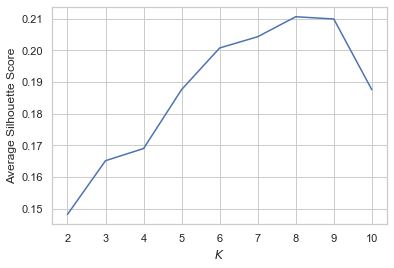

In [92]:
from sklearn import metrics

krange = list(range(2,11))
avg_silhouettes = []

# perform k-means, calculate & plot Silhouette Scores
for n in krange:
    
    kmeans = cluster.KMeans(n_clusters=n, random_state=10)
    cluster_assignments = kmeans.fit_predict(offer_completed_bycus[cols])
    
    silhouette_avg = metrics.silhouette_score(offer_completed_bycus[cols], cluster_assignments)
    avg_silhouettes.append(silhouette_avg)

# plot the result by plotting krange against avg_silhouettes
plt.plot(krange, avg_silhouettes)
plt.xlabel("$K$")
plt.ylabel("Average Silhouette Score")
plt.show()

**Comment:** from the above plot, we can see that k=8 has the best silhouette score. This is inline with the Elbow method we used previously.

In [93]:
# perform k-means clustering again with the best k found above
# print its sihouette score 

kmeans = cluster.KMeans(n_clusters=8, random_state=10)
kmeans.fit_predict(offer_completed_bycus[cols])

km_silhouette = metrics.silhouette_score(offer_completed_bycus[cols], kmeans.labels_)

print('k-means silhouette score: ' + str(km_silhouette))

k-means silhouette score: 0.21063584067647917


In [94]:
# perform k-modes clustering again with the best k found above
# print its sihouette score 

kmodes = KModes(n_clusters=8)
offer_completed_bycus['kmodes_cluster'] = kmodes.fit_predict(offer_completed_bycus[cols])

km_silhouette = metrics.silhouette_score(offer_completed_bycus[cols], kmodes.labels_)

print('k-modes silhouette score: ' + str(km_silhouette))

k-modes silhouette score: 0.025736221444745744


Note that the k-means silhouette score is much higher than the k-modes silhouette score using the best value of k (k=8). This means the k-means method is better fit for this dataset.

# Analyse customer segments
1. Combine data from above clustering results, profile df, transaction df, and completed_not_view_master df. 
2. Analyse the combined data to find out how can we improve the relevancy of our offers to customers & better make use of each offer sent

##### 1. Combine data from above clustering results, profile df, transaction df, and completed_not_view_master df

In [97]:
# create transaction_bycus dataframe from transaction dataframe
transaction_bycus = pd.DataFrame(transaction.groupby(['person'])['transaction_value'].mean())

# combined the offer_completed_bycus, the profile, and the transaction_bycus dataframe to look at demographic as well as avg spend details in each cluster
profile_offer_completed_bycus = pd.concat([offer_completed_bycus.set_index('person'), profile.set_index('id'), transaction_bycus, completed_not_view_master], axis=1, sort=False)

In [98]:
# select relevant columns, drop standardized columns used in k-means
profile_offer_completed_bycus = profile_offer_completed_bycus[['kmeans_cluster',
                                  'age', 'days_since_became_member', 'income','gender',
                                  'gender_F', 'gender_M', 'gender_O','transaction_value','total_completed_not_view'
                                 ]]

In [99]:
# select rows where we have customer profile data
profile_offer_completed_bycus = profile_offer_completed_bycus[profile_offer_completed_bycus['age'].notna()]

In [100]:
# select rows those who have completed at least 1 offer
profile_offer_completed_bycus = profile_offer_completed_bycus[profile_offer_completed_bycus['kmeans_cluster'].notna()]

##### 2. Analyse the combined data to find out how can we improve the relevancy of our offers to customers & better make use of each offer sent

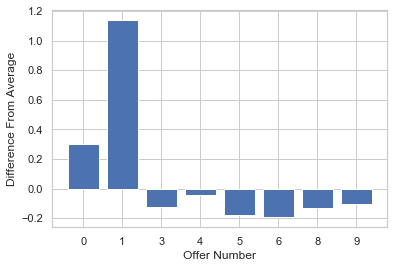

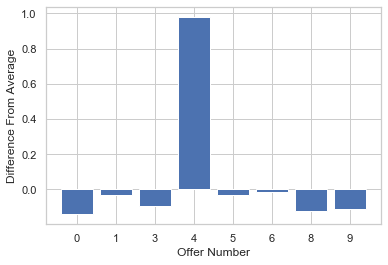

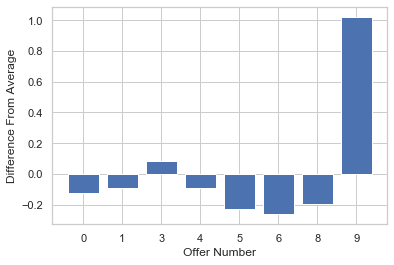

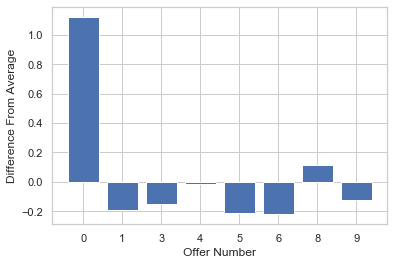

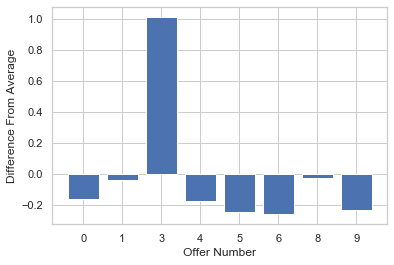

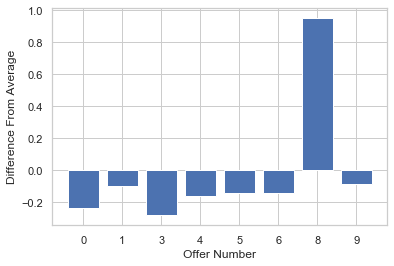

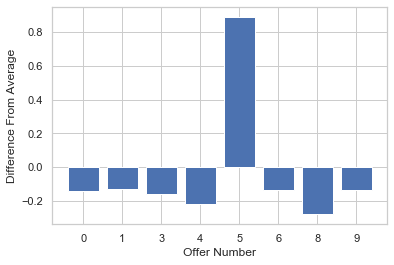

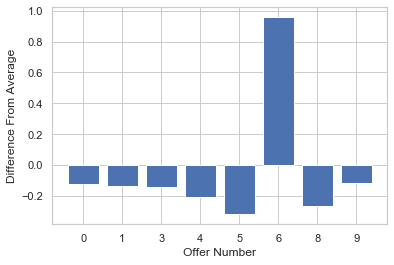

In [101]:
# visualise how each segment (cluster) differs from the average in each offer type (features) -
# which is the difference between the proportion of customers in each cluster that responded to an offer and the proportion of customers overall that responded to an offer, for each of the offers

total_proportions = offer_completed_bycus[offer_cols].mean()

for i in range(8):
    plt.figure(i)
    cluster_df = offer_completed_bycus[offer_completed_bycus['kmeans_cluster'] == i]
    cluster_proportions = cluster_df[offer_cols].mean()
    offer_labels = [x[:1] for x in list(offer_completed_bycus[offer_cols].columns)]

    diff = cluster_proportions - total_proportions
    plt.bar(offer_labels, diff)
    plt.xlabel('Offer Number')
    plt.ylabel('Difference From Average')
    
plt.show()

**Comment:** From the above visualisation of how each segment (cluster) differs from the average in each offer type we can see that:
1. Customers in cluster 0 are likely to respond to offer #1, #0
2. Customers in cluster 1 are likely to respond to offer #4
3. Customers in cluster 2 are likely to respond to offer #9, #3
4. Customers in cluster 3 are likely to respond to offer #0, #8
5. Customers in cluster 4 are likely to respond to offer #3
6. Customers in cluster 5 are likely to respond to offer #8
7. Customers in cluster 6 are likely to respond to offer #5
8. Customers in cluster 7 are likely to respond to offer #6

These insights can give us idea which offer(s) to send to each of these cluster (customer groups) in the future.


In [102]:
# summarise customers profile by mean of age, income, gender, days since became member, transaction value, and total_completed_not_view
profile_offer_completed_bycus.groupby(['kmeans_cluster']).mean().sort_values(by=['income','days_since_became_member','transaction_value']).reset_index().sort_values(by=['kmeans_cluster'])

,kmeans_cluster,age,days_since_became_member,income,gender_F,gender_M,gender_O,transaction_value,total_completed_not_view
7,0.0,57.350810,1245.092469,73577.693041,0.543375,0.448046,0.008580,21.381671,3.315539
5,1.0,56.945732,1249.188415,71676.829268,0.498780,0.484146,0.017073,20.332021,3.082927
4,2.0,55.285922,1238.313498,68946.298984,0.451379,0.531205,0.017417,18.333810,2.809144
6,3.0,56.426357,1212.767442,71839.793282,0.490956,0.490095,0.018949,20.359243,2.968992
3,4.0,55.273328,1214.218222,66346.069067,0.437913,0.545922,0.016165,16.116885,2.590007
2,5.0,54.544218,1212.483612,65679.653680,0.415584,0.567718,0.016698,15.799839,2.491033
0,6.0,53.458333,1233.436303,64064.655172,0.411877,0.574713,0.013410,14.100953,2.409004
1,7.0,54.239362,1237.034279,64810.874704,0.403664,0.585106,0.011229,14.868083,2.369385


**Comment:** As shown in the above summary table, groups of customers (cluster 0, 1 & 3) who have avg. transaction value of 20 dollars or more, have avg. of at least 3 completed offers not view. And nearly 50% or more customers in these 3 groups are female, compared to other groups have avg. 45% or less female. 

These insights lead us to the question that if we should reduce the number of offers sent to these groups as these customers would have made purchases without receiving an offer. Assuming the purpose of sending an offer is to encourage purchase, then in this case the offers sent didn't have an impact on buying behaviour of these groups of customers. In other words, if we continue to send offers without considering this factor, we're making a incorrect investment and not optimising the advertising budget.

It is recommended to run testing before making any permanent change. One reason is even though these customers didn't view the offer before making purchase, but receiving rewards every now and then may have some level of impact on repeating purchases.